In [1]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

# Here are my rc parameters for matplotlib
mpl.rc('font', serif='Helvetica Neue') 
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['figure.figsize'] = 3.2, 2.8
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['axes.linewidth'] = 1.5

# This link shows you how to greyscale a cmap
# https://jakevdp.github.io/PythonDataScienceHandbook/04.07-customizing-colorbars.html

def find(name):
    home = os.path.expanduser("~")
    for root, dirs, files in os.walk(home):
        if name in dirs:
            return os.path.join(root, name)

# First let's find all of our data
whingPath = find('whingdingdilly')
ipyPath = whingPath + '/ipython'
rootPath = ipyPath + '/epsilon_1_find_diameter'
epsOneMono = rootPath + '/mono/diamTxt'
epsOneParFrac = rootPath + '/varyParticleFraction/diamTxts'
epsOnePeRat = rootPath + '/5050mix/eps1_mix_txts'
epsHSMono = rootPath + '/HS_mono/diamTxt'

# Populate my file containers
fileContainer = []
pathContainer = []
os.chdir(rootPath)
fileContainer.append(os.listdir(epsOneMono))
fileContainer.append(os.listdir(epsOneParFrac))
fileContainer.append(os.listdir(epsOnePeRat))
fileContainer.append(os.listdir(epsHSMono))
pathContainer.append(epsOneMono)
pathContainer.append(epsOneParFrac)
pathContainer.append(epsOnePeRat)
pathContainer.append(epsHSMono)

nSweeps = len(fileContainer)
# Get rid of ugly files
for i in xrange(nSweeps):
    if '.DS_Store' in fileContainer[i]:
        fileContainer[i].remove('.DS_Store')

In [2]:
# Functions to sort my data with
def getFromTxt(fname, first, last):
    """Takes a string, text before and after desired text, outs text between"""
    start = fname.index( first ) + len( first )
    end = fname.index( last, start )
    myTxt = fname[start:end]
    return float(myTxt)
        
def multiSort(arr1, arr2, arr3):
    """Sort an array the slow (but certain) way, returns original indices in sorted order"""
    # Doing this for PeR, PeS, xS in this case
    cpy1 = np.copy(arr1)
    cpy2 = np.copy(arr2)
    cpy3 = np.copy(arr3)
    ind = np.arange(0, len(arr1))
    for i in xrange(len(cpy1)):
        for j in xrange(len(cpy1)):
            # Sort by first variable
            if cpy1[i] > cpy1[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            # If first variable is equal, resort to second variable
            elif cpy1[i] == cpy1[j] and cpy2[i] > cpy2[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            elif cpy1[i] == cpy1[j] and cpy2[i] == cpy2[j] and cpy3[i] > cpy3[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]      
    return ind

def indSort(arr1, arr2):
    """Take sorted index array, use to sort array"""
    # arr1 is array to sort
    # arr2 is index array
    cpy = np.copy(arr1)
    for i in xrange(len(arr1)):
        arr1[i] = cpy[arr2[i]]

In [3]:
# Load data pre-sorted
for i in xrange(nSweeps):
    paList = []
    pbList = []
    xfList = []
    for j in xrange(len(fileContainer[i])):
        paList.append(getFromTxt(fileContainer[i][j], "pa", "_pb"))
        pbList.append(getFromTxt(fileContainer[i][j], "pb", "_xa"))
        try:
            xfList.append(getFromTxt(fileContainer[i][j], "xa", "_ep"))
        except:
            xfList.append(getFromTxt(fileContainer[i][j], "xa", ".txt"))
        xfList[j] = 100.0 - xfList[j]
    # Now sort the array of txtFile names
    indArr = multiSort(paList, pbList, xfList)
    indSort(fileContainer[i], indArr)
    
# for i in xrange(len(fileContainer[0])):
#     print(fileContainer[0][i])

In [4]:
# Read the data for each parameter study into a pandas dataframe
all_sims = []
for i in xrange(nSweeps):
    all_sims.append([])
    os.chdir(pathContainer[i])
    for j in xrange(len(fileContainer[i])):
        df = pd.read_csv(fileContainer[i][j], sep='\s+', header=0)
        all_sims[i].append(df)
        
# Go back to the source folder (save figures here)
os.chdir(rootPath)        

# Get the name of each of the headers in the dataframes
list(all_sims[0][0])

['Timestep',
 'Gas_A',
 'Gas_B',
 'Gas_tot',
 'Dense_A',
 'Dense_B',
 'Dense_tot',
 'Lg_clust',
 'MCS',
 'sigALL',
 'sigAA',
 'sigAB',
 'sigBB',
 'phiEff',
 'lg_clustA',
 'tot_clustA',
 'LC_density',
 'DP_density',
 'GP_density']

In [5]:
# Make sure all data is chronilogical
def chkSort(array):
    """Make sure array is chronilogical"""
    for i in xrange(len(array)-2):
        if array[i] > array[i+1]:
            print("{} is not greater than {} for indices=({},{})").format(array[i+1], array[i], i, i+1)
            return False
    return True

# Check to see if timesteps are in order
for i in xrange(nSweeps):
    for j in xrange(len(fileContainer[i])):
        myBool = chkSort(all_sims[i][j]['Timestep'])
        if myBool is False:
            print("{} is not chronilogically sorted!").format(fileContainer[i][j])
            exit(1)
        else:
            print("{} sorted... ").format(fileContainer[i][j])

diam_pa0_pb0_xa100.txt sorted... 
diam_pa50_pb0_xa100.txt sorted... 
diam_pa100_pb0_xa100.txt sorted... 
diam_pa150_pb0_xa100.txt sorted... 
diam_pa200_pb0_xa100.txt sorted... 
diam_pa250_pb0_xa100.txt sorted... 
diam_pa300_pb0_xa100.txt sorted... 
diam_pa350_pb0_xa100.txt sorted... 
diam_pa400_pb0_xa100.txt sorted... 
diam_pa450_pb0_xa100.txt sorted... 
diam_pa500_pb0_xa100.txt sorted... 
diam_pa150_pb500_xa100.txt sorted... 
diam_pa150_pb500_xa90.txt sorted... 
diam_pa150_pb500_xa80.txt sorted... 
diam_pa150_pb500_xa70.txt sorted... 
diam_pa150_pb500_xa60.txt sorted... 
diam_pa150_pb500_xa50.txt sorted... 
diam_pa150_pb500_xa40.txt sorted... 
diam_pa150_pb500_xa30.txt sorted... 
diam_pa150_pb500_xa20.txt sorted... 
diam_pa150_pb500_xa10.txt sorted... 
diam_pa150_pb500_xa0.txt sorted... 
diam_pa0_pb500_xa50.txt sorted... 
diam_pa50_pb500_xa50.txt sorted... 
diam_pa100_pb500_xa50.txt sorted... 
diam_pa150_pb500_xa50.txt sorted... 
diam_pa200_pb500_xa50.txt sorted... 
diam_pa250_pb500_x

In [6]:
display(all_sims[0][0])

,Timestep,Gas_A,Gas_B,Gas_tot,Dense_A,Dense_B,Dense_tot,Lg_clust,MCS,sigALL,sigAA,sigAB,sigBB,phiEff,lg_clustA,tot_clustA,LC_density,DP_density,GP_density
0,0.0,200000,0,200000,0,0,0,20,0,1.0127,1.0127,0.0,0.0,0.61,16.1,0.0,1.24,0.0,0.76
1,200000.0,200000,0,200000,0,0,0,17,0,1.0212,1.0212,0.0,0.0,0.61,13.9,0.0,1.22,0.0,0.76
2,400000.0,200000,0,200000,0,0,0,13,0,1.0088,1.0088,0.0,0.0,0.61,10.4,0.0,1.25,0.0,0.76
3,600000.0,200000,0,200000,0,0,0,18,0,1.0106,1.0106,0.0,0.0,0.61,14.4,0.0,1.25,0.0,0.76
4,800000.0,200000,0,200000,0,0,0,13,0,1.0048,1.0048,0.0,0.0,0.60,10.3,0.0,1.26,0.0,0.76
5,1000000.0,200000,0,200000,0,0,0,13,0,1.0255,1.0255,0.0,0.0,0.62,10.7,0.0,1.21,0.0,0.76
6,1200000.0,200000,0,200000,0,0,0,13,0,1.0120,1.0120,0.0,0.0,0.61,10.5,0.0,1.24,0.0,0.76
7,1400000.0,200000,0,200000,0,0,0,11,0,1.0079,1.0079,0.0,0.0,0.60,8.8,0.0,1.25,0.0,0.76
8,1600000.0,200000,0,200000,0,0,0,17,0,1.0034,1.0034,0.0,0.0,0.60,13.4,0.0,1.26,0.0,0.76
9,1800000.0,200000,0,200000,0,0,0,11,0,1.0175,1.0175,0.0,0.0,0.61,8.9,0.0,1.23,0.0,0.76


In [7]:
# Function that will sort wrt one variable
def singleSort(arr):
    for i in xrange(len(arr)):
        for j in xrange(len(arr)):
            if arr[i] < arr[j] and i > j:
                arr[i], arr[j] = arr[j], arr[i]
                
# Function to get conversion from timesteps to Brownian time
def computeTauPerTstep(epsilon):
    # This is actually indpendent of runtime :)
#     sigma = 1.0
#     threeEtaPiSigma = 1.0
#     runFor = 200
#     tauBrown = 1.0
#     tauLJ = ((sigma**2) * threeEtaPiSigma) / epsilon
#     dt = 0.00001 * tauLJ
#     simLength = runFor * tauBrown
#     totTsteps = int(simLength / dt)
#     tstepPerTau = int(totTsteps / float(simLength))
    kBT = 1.0
    tstepPerTau = int(epsilon / (kBT * 0.00001))
    return tstepPerTau

def theoryDenom(xF, peS, peF):
    xF /= 100.0
    xS = 1.0 - xF
    return 4.0 * ((xS * peS) + (xF * peF))

def theory(xF, peS, peF):
    kappa = 4.05
    xF /= 100.0
    xS = 1.0 - xF
    return ((3.0 * (np.pi**2) * kappa) / (4.0 * ((xS * peS) + (xF * peF))))

# Make an additional frame that gives total number of particles, and simulation parameters
params = []
for i in xrange(nSweeps):
    paramList = []
    for j in xrange(len(fileContainer[i])):
        partAll = all_sims[i][j]['Gas_tot'][0]
        partA = all_sims[i][j]['Gas_A'][0]
        partB = all_sims[i][j]['Gas_B'][0]
        pa = getFromTxt(fileContainer[i][j], "pa", "_pb")
        pb = getFromTxt(fileContainer[i][j], "pb", "_xa")
        # File naming convention is different for these files
        try:
            xa = getFromTxt(fileContainer[i][j], "xa", "_ep")
        except:
            xa = getFromTxt(fileContainer[i][j], "xa", ".txt")
        # Is epsilon in the filename?
        try:
            eps = getFromTxt(fileContainer[i][j], "ep", ".txt")
        except:
            eps = 0
            
        xf = 100.0 - xa

        paramList.append((partAll, partA, partB, pa, pb, xf, eps))

    # Put the data for this parameter sweep into it's own dataframe
    params.append(pd.DataFrame(paramList, columns=['partAll',
                                                  'partA',
                                                  'partB',
                                                  'peA',
                                                  'peB',
                                                  'xF',
                                                  'eps'])
                 )
    pd.set_option('display.max_rows', 2)
    display(params[i])

,partAll,partA,partB,peA,peB,xF,eps
0,200000,200000,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...
10,161244,161244,0,500.0,0.0,0.0,0


,partAll,partA,partB,peA,peB,xF,eps
0,149797,149797,0,150.0,500.0,0.0,0
...,...,...,...,...,...,...,...
10,165030,0,165030,150.0,500.0,100.0,0


,partAll,partA,partB,peA,peB,xF,eps
0,339474,172757,166717,0.0,500.0,50.0,0
...,...,...,...,...,...,...,...
10,438951,219450,219501,500.0,500.0,50.0,0


,partAll,partA,partB,peA,peB,xF,eps
0,100000,100000,0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
10,100000,100000,0,500.0,0.0,0.0,82.0


In [8]:
# Now get time-based steady state values
all_SS = []
all_stdDev = []
all_var = []
startInd = 50
for i in xrange(nSweeps):
    # Make list of steady state column headers
    headers = list(all_sims[i][0])
    headers.remove('Timestep')
    SS = pd.DataFrame(columns=headers)
    stdDev = pd.DataFrame(columns=headers)
    var = pd.DataFrame(columns=headers)
    # Initialize dataframes
    for j in xrange(len(fileContainer[i])):
        SS.loc[j] = [0] * len(headers)
        stdDev.loc[j] = [0] * len(headers)
        var.loc[j] = [0] * len(headers)

    # Make dataframe of steady-state data
    for j in xrange(len(fileContainer[i])):
        # Loop through each column (aside from tstep column)
        for k in range(1, len(all_sims[i][j].iloc[1])):
            # Compute mean of data after steady-state time (25tb) in jth column of ith file
            avg = np.mean(all_sims[i][j].iloc[startInd:-1, k])
            SS[headers[k-1]][j] = avg
            # Compute the standard deviation and variance in this data
            stdDevor = np.std(all_sims[i][j].iloc[startInd:-1, k])
            stdDev[headers[k-1]][j] = stdDevor
            var[headers[k-1]][j] = stdDevor ** 2

    # Normalize by number of particles
    for j in xrange(len(fileContainer[i])):
        if params[i]['partA'][j] != 0:
            SS['Gas_A'][j] /= params[i]['partA'][j]
            SS['Dense_A'][j] /= params[i]['partA'][j]
            # Now my standard error is a percentage
            stdDev['Gas_A'][j] /= params[i]['partA'][j]
            stdDev['Dense_A'][j] /= params[i]['partA'][j]
            var['Gas_A'][j] /= params[i]['partA'][j]
            var['Dense_A'][j] /= params[i]['partA'][j]

        if params[i]['partB'][j] != 0:
            SS['Gas_B'][j] /= params[i]['partB'][j]
            SS['Dense_B'][j] /= params[i]['partB'][j]
            stdDev['Gas_B'][j] /= params[i]['partB'][j]
            stdDev['Dense_B'][j] /= params[i]['partB'][j]
            var['Gas_B'][j] /= params[i]['partB'][j]
            var['Dense_B'][j] /= params[i]['partB'][j]

    SS['Gas_tot'][:] /= params[i]['partAll'][:]
    SS['Dense_tot'][:] /= params[i]['partAll'][:] 
    SS['Lg_clust'][:] /= params[i]['partAll'][:] 
    SS['MCS'][:] /= params[i]['partAll'][:]
    stdDev['Gas_tot'][:] /= params[i]['partAll'][:]
    stdDev['Dense_tot'][:] /= params[i]['partAll'][:] 
    stdDev['Lg_clust'][:] /= params[i]['partAll'][:] 
    stdDev['MCS'][:] /= params[i]['partAll'][:]
    var['Gas_tot'][:] /= params[i]['partAll'][:]
    var['Dense_tot'][:] /= params[i]['partAll'][:] 
    var['Lg_clust'][:] /= params[i]['partAll'][:] 
    var['MCS'][:] /= params[i]['partAll'][:]

    SS['Gas_A'][:] *= 100.0
    SS['Gas_B'][:] *= 100.0
    SS['Gas_tot'][:] *= 100.0
    SS['Dense_A'][:] *= 100.0
    SS['Dense_B'][:] *= 100.0
    SS['Dense_tot'][:] *= 100.0
    SS['Lg_clust'][:] *= 100.0
    SS['MCS'][:] *= 100.0
    stdDev['Gas_A'][:] *= 100.0
    stdDev['Gas_B'][:] *= 100.0
    stdDev['Gas_tot'][:] *= 100.0
    stdDev['Dense_A'][:] *= 100.0
    stdDev['Dense_B'][:] *= 100.0
    stdDev['Dense_tot'][:] *= 100.0
    stdDev['Lg_clust'][:] *= 100.0
    stdDev['MCS'][:] *= 100.0
    var['Gas_A'][:] *= 100.0
    var['Gas_B'][:] *= 100.0
    var['Gas_tot'][:] *= 100.0
    var['Dense_A'][:] *= 100.0
    var['Dense_B'][:] *= 100.0
    var['Dense_tot'][:] *= 100.0
    var['Lg_clust'][:] *= 100.0
    
    # Put these values into the modular container
    all_SS.append(SS)
    all_stdDev.append(stdDev)
    all_var.append(var)
    # Delete these and loop through next parameter sweep
    del SS
    del stdDev
    del var
    
pd.set_option('display.max_rows', 6)
display(all_SS[0])

,Gas_A,Gas_B,Gas_tot,Dense_A,Dense_B,Dense_tot,Lg_clust,MCS,sigALL,sigAA,sigAB,sigBB,phiEff,lg_clustA,tot_clustA,LC_density,DP_density,GP_density
0,100,0,100,0,0,0,0.00677713,0,1.00643,1.00643,0,0,0.603319,10.7824,0,1.25723,0,0.76
1,58.4186,0,58.4186,41.5814,0,41.5814,5.88721,1.77177,0.974214,0.974214,0,0,0.584636,8775.57,61992.1,1.34183,1.34183,0.584489
2,30.3731,0,30.3731,82.4364,0,82.4364,19.2511,13.4379,0.874042,0.874042,0,0,0.523994,20469,87692.1,1.66666,1.66666,0.309347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,15.6058,0,15.6058,114.432,0,114.432,111.307,105.647,0.765704,0.765704,0,0,0.46,78833.9,81045.4,2.17174,2.17174,0.132753
9,13.304,0,13.304,100.331,0,100.331,87.5183,83.5668,0.75691,0.75691,0,0,0.452451,69305.9,79458,2.2224,2.2224,0.1285
10,13.8433,0,13.8433,110.192,0,110.192,101.873,98.5832,0.748928,0.748928,0,0,0.449989,72354.3,78273,2.27008,2.27008,0.121517


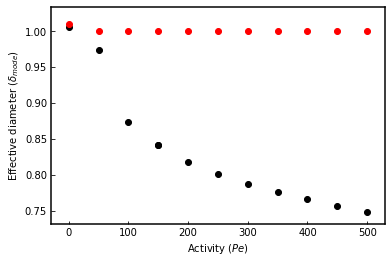

In [9]:
# Now make figure plots
for i in xrange(nSweeps):
    for j in xrange(len(fileContainer[i])):
        if params[i]['xF'][j] == 0 and params[i]['eps'][j] == 0:
            plt.scatter(params[i]['peA'][j], all_SS[i]['sigALL'][j],
                        c='k')
for i in xrange(nSweeps):
    for j in xrange(len(fileContainer[i])):
        if params[i]['xF'][j] == 0 and params[i]['eps'][j] != 0:
            plt.scatter(params[i]['peA'][j], all_SS[i]['sigALL'][j],
                        c='r')
            
plt.xlabel(r'Activity $(Pe)$')
plt.ylabel(r'Effective diameter $(\delta_{mode})$')
plt.show()

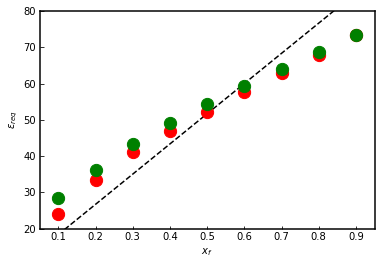

In [10]:
# Make the inset individually, then add figures together
def deltaToForce(delta):
    sig = 1.0
    eps = 1.0
    ljForce = 24.0 * eps * ( (2*((sig**12)/(delta**13))) - ((sig**6)/(delta**7)) )
    return ljForce

def deltaToEpsReq(delta):
    FLJ = deltaToForce(delta)
    epsReq = FLJ / 24.0
    return epsReq

def netEpsilon(xF, peS, peF):
    epsBrown = 10.0
    sig = 1.0
    xF /= 100.0
    xS = 1.0 - xF
    netEps = (4.0*((peF*sig*xF) + (peS*sig*xS)) / 24.0) + epsBrown
    return netEps

for j in xrange(len(fileContainer[1])):
    if params[1]['xF'][j] % 100.0 != 0:
        epsReqAll = deltaToEpsReq(all_SS[1]['sigALL'][j])
        epsReqAA = deltaToEpsReq(all_SS[1]['sigAA'][j])
        epsReqAB = deltaToEpsReq(all_SS[1]['sigAB'][j])
        epsReqBB = deltaToEpsReq(all_SS[1]['sigBB'][j])
        plt.scatter(params[1]['xF'][j] / 100.0, epsReqAA, c='r', s=150, zorder=1)
#         plt.scatter(params[1]['xF'][j] / 100.0, epsReqAB, c='b', s=150, zorder=1)
        plt.scatter(params[1]['xF'][j] / 100.0, epsReqBB, c='g', s=150, zorder=1)

# Get a line for the data
xline = np.arange(0.0, 100.0, 0.001)
yline = np.zeros_like(xline)
for i in xrange(len(xline)):
    yline[i] = netEpsilon(xline[i], 0.0, 500.0)
plt.plot(xline / 100.0, yline, linestyle='--', c='k', lw=1.5, zorder=0)

plt.xlabel(r'$x_{f}$')
plt.ylabel(r'$\epsilon_{req}$')
plt.xlim(0.05, 0.95)
plt.ylim(20, 80)
plt.show()

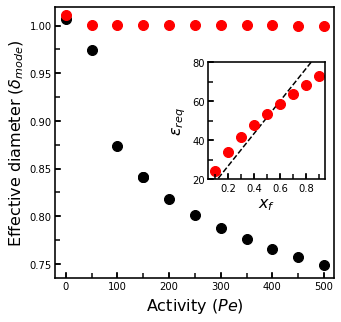

In [11]:
# Let's combine those last two plots and make the figure look nice
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
mpl.rcParams['axes.linewidth'] = 1.6
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fontsz = 16

# Larger figure
for i in xrange(nSweeps):
    for j in xrange(len(fileContainer[i])):
        if params[i]['xF'][j] == 0 and params[i]['eps'][j] == 0:
            ax.scatter(params[i]['peA'][j], all_SS[i]['sigALL'][j],
                        c='k', s=100)
for i in xrange(nSweeps):
    for j in xrange(len(fileContainer[i])):
        if params[i]['xF'][j] == 0 and params[i]['eps'][j] != 0:
            ax.scatter(params[i]['peA'][j], all_SS[i]['sigALL'][j],
                        c='r', s=100)
            
ax.set_xlim(-20, 520)
ax.set_ylim(0.735, 1.02)
ax.set_xlabel(r'Activity $(Pe)$', fontsize=fontsz)
ax.set_ylabel(r'Effective diameter $(\delta_{mode})$', fontsize=fontsz)

# Inset figure
left, bottom, width, height = [0.55, 0.40, 0.325, 0.325]
ax2 = fig.add_axes([left, bottom, width, height])

for j in xrange(len(fileContainer[1])):
    if params[1]['xF'][j] % 100.0 != 0:
        epsReqAll = deltaToEpsReq(all_SS[1]['sigALL'][j])
        epsReqAA = deltaToEpsReq(all_SS[1]['sigAA'][j])
        epsReqAB = deltaToEpsReq(all_SS[1]['sigAB'][j])
        epsReqBB = deltaToEpsReq(all_SS[1]['sigBB'][j])
        ax2.scatter(params[1]['xF'][j] / 100.0, epsReqAll, c='r', s=100, zorder=1)

# Get a line for the data
xline = np.arange(0.0, 100.0, 0.001)
yline = np.zeros_like(xline)
for i in xrange(len(xline)):
    yline[i] = netEpsilon(xline[i], 0.0, 500.0)
ax2.plot(xline / 100.0, yline, linestyle='--', c='k', lw=1.5, zorder=0)

ax2.set_xlabel(r'$x_{f}$', fontsize=fontsz)
ax2.set_ylabel(r'$\epsilon_{req}$', fontsize=fontsz)
ax2.set_xlim(0.05, 0.95)
ax2.set_ylim(20, 80)

# Set ticks for first plot
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.025))
# Set tick dims
ax.tick_params(which='major', length=6, width = 1.5)
ax.tick_params(which='minor', length=5, width = 1.5)

# Set ticks for second plot
ax2.xaxis.set_major_locator(MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(MultipleLocator(0.1))
ax2.yaxis.set_major_locator(MultipleLocator(20))
ax2.yaxis.set_minor_locator(MultipleLocator(10))
# Set tick dims
ax2.tick_params(which='major', length=6, width = 1.5)
ax2.tick_params(which='minor', length=5, width = 1.5)

# Save the figure as pdf
plt.savefig('diameter_data.pdf', dpi=2000, bbox_inches = 'tight', pad_inches = 0)

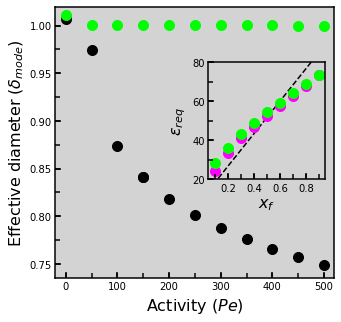

In [15]:
# Remake this figure with inset showing each type of interaction
overlayColr = ['#ff00ff', '#00ffff', '#00ff00']


from matplotlib.ticker import MultipleLocator, FormatStrFormatter
mpl.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fontsz = 16

# Larger figure
for i in xrange(nSweeps):
    for j in xrange(len(fileContainer[i])):
        if params[i]['xF'][j] == 0 and params[i]['eps'][j] == 0:
            ax.scatter(params[i]['peA'][j], all_SS[i]['sigALL'][j],
                        c='k', s=100)
for i in xrange(nSweeps):
    for j in xrange(len(fileContainer[i])):
        if params[i]['xF'][j] == 0 and params[i]['eps'][j] != 0:
            ax.scatter(params[i]['peA'][j], all_SS[i]['sigALL'][j],
                        c='#00ff00', s=100)
            
ax.set_xlim(-20, 520)
ax.set_ylim(0.735, 1.02)
ax.set_xlabel(r'Activity $(Pe)$', fontsize=fontsz)
ax.set_ylabel(r'Effective diameter $(\delta_{mode})$', fontsize=fontsz)

# Inset figure
left, bottom, width, height = [0.55, 0.40, 0.325, 0.325]
ax2 = fig.add_axes([left, bottom, width, height])

for j in xrange(len(fileContainer[1])):
    if params[1]['xF'][j] % 100.0 != 0:
        epsReqAll = deltaToEpsReq(all_SS[1]['sigALL'][j])
        epsReqAA = deltaToEpsReq(all_SS[1]['sigAA'][j])
        epsReqAB = deltaToEpsReq(all_SS[1]['sigAB'][j])
        epsReqBB = deltaToEpsReq(all_SS[1]['sigBB'][j])
        ax2.scatter(params[1]['xF'][j] / 100.0, epsReqAA, c='#ff00ff', s=100, zorder=1)
        ax2.scatter(params[1]['xF'][j] / 100.0, epsReqBB, c='#00ff00', s=100, zorder=1)

# Get a line for the data
xline = np.arange(0.0, 100.0, 0.001)
yline = np.zeros_like(xline)
for i in xrange(len(xline)):
    yline[i] = netEpsilon(xline[i], 0.0, 500.0)
ax2.plot(xline / 100.0, yline, linestyle='--', c='k', lw=1.5, zorder=0)

ax2.set_xlabel(r'$x_{f}$', fontsize=fontsz)
ax2.set_ylabel(r'$\epsilon_{req}$', fontsize=fontsz)
ax2.set_xlim(0.05, 0.95)
ax2.set_ylim(20, 80)

# Set ticks for first plot
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.025))
# Set tick dims
ax.tick_params(which='major', length=6, width = 1.5)
ax.tick_params(which='minor', length=5, width = 1.5)

# Set ticks for second plot
ax2.xaxis.set_major_locator(MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(MultipleLocator(0.1))
ax2.yaxis.set_major_locator(MultipleLocator(20))
ax2.yaxis.set_minor_locator(MultipleLocator(10))
# Set tick dims
ax2.tick_params(which='major', length=6, width = 1.5)
ax2.tick_params(which='minor', length=5, width = 1.5)
ax.set_facecolor('#d3d3d3')
ax2.set_facecolor('#d3d3d3')

# Save the figure as pdf
plt.savefig('diameter_data_types.pdf', dpi=2000, bbox_inches = 'tight', pad_inches = 0.01)

In [13]:
# This means that the best way to do this is with a weighted average
# epsilon_ALL = (4*PeF*sigma*xF + 4*PeS*sigma*xS) / 24.0

In [14]:
# I just need one of the above plots
